# CS7643 Final Project

This notebook is meant to go through the different models and experiment on our dataset containing 21782 training samples on different sounds. 

## Group Members
Zach Halaby
Michael Marzec
Shayan Mukhtar

## Dataset

The dataset was obtained under Google's GPL license terms from the following site: https://research.google.com/audioset/download.html

## Colab Prep

github <--> colab instructions: https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

In [1]:
### If using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Initial Cloning

In [ ]:
### cd to github drive (create the folder, if it doesn't already exist)
%cd /content/drive/MyDrive/Github

# git clone -b branch https://{git_token}@github.com/{username}/{repository}
# See instructions file if you're unfamiliar with generating git_tokens

username = 'shayanmukhtar'
repository = 'cs7643_final'
# git_token = 

# !git clone -b UPDATE_BRANCH https://{git_token}@github.com/{username}/{repository}



### Git Commands

#### access git (via Google Drive)

In [2]:
%cd /content/drive/MyDrive/Github

repository = 'cs7643_final'
%cd {repository}

%ls -a

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/cs7643_final
cs7643_final_project.ipynb  main_scratch.py  plots/     utils/
.git/                       models/          README.md


#### Commit / Status / Push

In [3]:
!git status

On branch marzec
Your branch is up to date with 'origin/marzec'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   cs7643_final_project.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [130]:
!git add .

In [131]:
# !git config user.email "michaelmarzec11@gmail.com"
!git commit -m "conv loss plots"

[marzec b2649d7] conv loss plots
 21 files changed, 1 insertion(+), 1 deletion(-)
 create mode 100644 plots/conv_lossPlot_16_0.0001_3_0.1.png
 create mode 100644 plots/conv_lossPlot_16_0.0001_3_0.4.png
 create mode 100644 plots/conv_lossPlot_16_0.001_3_0.2.png
 create mode 100644 plots/conv_lossPlot_32_0.0001_3_0.2.png
 create mode 100644 plots/conv_lossPlot_32_0.0001_3_0.4.png
 create mode 100644 plots/conv_lossPlot_32_0.001_3_0.01.png
 create mode 100644 plots/conv_lossPlot_32_0.001_3_0.1.png
 rewrite plots/conv_lossPlot_32_0.001_3_0.2.png (98%)
 create mode 100644 plots/conv_lossPlot_32_0.001_3_0.4.png
 create mode 100644 plots/conv_lossPlot_32_0.001_3_0.6.png
 create mode 100644 plots/conv_lossPlot_32_0.005_3_0.2.png
 create mode 100644 plots/conv_lossPlot_64_0.0001_3_0.3.png
 create mode 100644 plots/conv_lossPlot_64_0.001_3_0.2.png
 create mode 100644 plots/conv_lossPlot_64_0.01_3_0.1.png
 create mode 100644 plots/conv_lossPlot_64_0.01_3_0.3.png
 create mode 100644 plots/conv_los

In [132]:
!git push

Counting objects: 24, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (24/24), done.
Writing objects: 100% (24/24), 576.38 KiB | 7.79 MiB/s, done.
Total 24 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/shayanmukhtar/cs7643_final
   5c08b65..b2649d7  marzec -> marzec


## Instructions
Cells with a "Mandatory" in their title must be run. Cells with a title stating that running is optional do not have to be run.

## Mandatory - Imports

Let's start by importing the necessary packages:

In [4]:
!pip install torchmetrics
!pip install tfrecord

import os.path

import torch
import torchmetrics
import tfrecord
import numpy as np
from os import walk
import matplotlib.pyplot as plt

from torchmetrics import ConfusionMatrix
from torchmetrics import F1

from torch.utils.data import DataLoader

from models import LinearModel
from models import SimpleConvolutionModel
from models import SimpleRecurrentModel
from utils import utils
from utils import dataloader
from torch import nn
from torch import optim

# Tqdm progress bar
from tqdm import tqdm_notebook

     |████████████████████████████████| 332 kB 13.2 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
  Created wheel for tfrecord: filename=tfrecord-1.14.1-py3-none-any.whl size=15654 sha256=04c8a02c92542a39614ac1023fb78345292c7dddc67afa4a5449bba75f85872c
  Stored in directory: /root/.cache/pip/wheels/07/63/59/2a382bd2e3051f622bf8742e79f2641d78b29523680f57bf74
Successfully built tfrecord


## Mandatory - Load Training Data

Load the training data into memory

In [5]:
# Figure out which device this notebook is being run from
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

# Load the training data from memory. Note this training data was created
# by converting the tfrecord files from the original dataset
training_data = utils.load_pytorch_tensor('./utils/balanced_train_data.pt')
training_label = utils.load_pytorch_tensor('./utils/balanced_train_label.pt')

# make this multi-classification problem a binary classification problem by
# selecting all labels which contain a given class and making their label
# True, and all others False. In this case, 0 means select the speech class
training_label, count = utils.convert_multiclass_to_binary(0, training_label)
print("Total of " + str(count) + " positive examples out of " + str(training_label.shape[0]) + " samples")

# convert the training data to floating point
training_data = np.float32(training_data)

# split the training data into two parts, one for training and the other for validation
data_train, label_train, data_val, label_val = utils.split_data_train_val(training_data, training_label)

# put on the right device
data_train = torch.from_numpy(data_train).to(device)
label_train = torch.from_numpy(label_train).to(device)
data_val = torch.from_numpy(data_val).to(device)
label_val = torch.from_numpy(label_val).to(device)

# Load the dataset into an iterable object from which batches can be made
train_dataset = dataloader.MusicDataset(data_train, label_train)
val_dataset = dataloader.MusicDataset(data_val, label_val)

You are using device: cuda
Total of 5668 positive examples out of 21782 samples


## Optional - Simple Linear Model

Let's get a training loop running with this simple linear model, which is nothing but an input, a ReLu, and an output

In [127]:
# Linear Model Hyperparameters

BATCH_SIZE = 32
LEARNING_RATE = .001
HIDDEN_LAYER_SIZE = 64
NUM_EPOCHS = 20

In [128]:
# Linear Model boilerplate code

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

linear_model = LinearModel.LinearModel(10*128, HIDDEN_LAYER_SIZE, 2).to(device)
optimizer = optim.Adam(linear_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

In [129]:
avg_train_loss_list = []
avg_val_loss_list = []

for epoch_idx in range(NUM_EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = utils.train(linear_model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = utils.evaluate(linear_model, val_loader, criterion)

    avg_train_loss = avg_train_loss.item()
    avg_val_loss = avg_val_loss.item()
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))

    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)

-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Training Loss: 1.3316. Validation Loss: 0.5840. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Training Loss: 0.5791. Validation Loss: 0.5708. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Training Loss: 0.5746. Validation Loss: 0.5685. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Training Loss: 0.5745. Validation Loss: 0.5672. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Training Loss: 0.5745. Validation Loss: 0.5673. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

Training Loss: 0.5744. Validation Loss: 0.5672. 


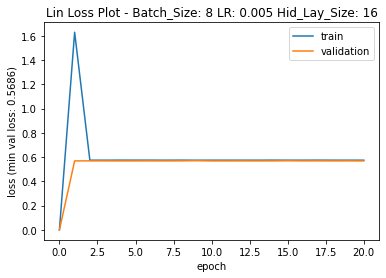

In [8]:
#fileName
file_name = "plots/linear_lossPlot_" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE) + "_" + str(HIDDEN_LAYER_SIZE) + ".png"
title =  "Lin Loss Plot - Batch_Size: " + str(BATCH_SIZE) + " LR: " + str(LEARNING_RATE) + " Hid_Lay_Size: " + str(HIDDEN_LAYER_SIZE)
min_val_loss = round(min(avg_val_loss_list),4)
y_axis = "loss (min val loss: " + str(min_val_loss) + ")"

#axis/graph prep
avg_train_loss_list.insert(0,0)
avg_val_loss_list.insert(0,0)
x_axis = np.arange(0,(NUM_EPOCHS + 1),1)


plt.plot(x_axis, avg_train_loss_list, label='train')
plt.plot(x_axis, avg_val_loss_list, label='validation')
plt.xlabel('epoch')
plt.ylabel(y_axis)
plt.title(title)
plt.legend()
plt.savefig(file_name)
plt.show();

## Optional - Simple Convolutional Model

Using convolution for sound identification is an established method and has been used on this dataset before. The idea is to make the learnable kernel 1-D and stride it across the sound artifacts. In this simple convolutional model, all 10 seconds of sounds will get flattened into one tensor, and a 1-D kernel strided. 

In [133]:
# Simple Convolution Model Hyperparameters
BATCH_SIZE = 8 # 32
LEARNING_RATE = .01 #.001
NUM_EPOCHS = 100

START_KERNEL_SIZE = 3 # 3
DROPOUT_RATE = 0.2 # 0.2

In [120]:
# Convolution Boilerplate code
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

convolution_model = SimpleConvolutionModel.SimpleConvolutionModel(START_KERNEL_SIZE, DROPOUT_RATE).to(device)
optimizer = optim.Adam(convolution_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

In [121]:
avg_train_loss_list = []
avg_val_loss_list = []

for epoch_idx in range(NUM_EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = utils.train(convolution_model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = utils.evaluate(convolution_model, val_loader, criterion)

    avg_train_loss = avg_train_loss.item()
    avg_val_loss = avg_val_loss.item()
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))

    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)

-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 158.1973. Validation Loss: 70.1567. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 83.0514. Validation Loss: 62.2480. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 181.4292. Validation Loss: 102.0291. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 144.6852. Validation Loss: 465.5094. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 191.4514. Validation Loss: 562.7045. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 193.2168. Validation Loss: 267.4085. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 206.2349. Validation Loss: 153.4817. 
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 231.4379. Validation Loss: 258.8636. 
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 259.7383. Validation Loss: 250.0118. 
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 227.9544. Validation Loss: 331.4166. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 253.1331. Validation Loss: 158.7666. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 262.8502. Validation Loss: 618.3207. 
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 249.0612. Validation Loss: 360.1932. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 42.5732. Validation Loss: 21.3921. 
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 24.3540. Validation Loss: 23.4151. 
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 23.6307. Validation Loss: 26.7546. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 23.6873. Validation Loss: 24.9544. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 22.3717. Validation Loss: 22.7719. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 21.9745. Validation Loss: 24.8622. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 20.5692. Validation Loss: 26.8404. 
-----------------------------------
Epoch 21
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 20.6691. Validation Loss: 22.3231. 
-----------------------------------
Epoch 22
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 19.9270. Validation Loss: 26.9142. 
-----------------------------------
Epoch 23
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 19.4582. Validation Loss: 21.1171. 
-----------------------------------
Epoch 24
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 18.9453. Validation Loss: 19.5461. 
-----------------------------------
Epoch 25
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 18.5463. Validation Loss: 24.8656. 
-----------------------------------
Epoch 26
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 18.7102. Validation Loss: 25.5443. 
-----------------------------------
Epoch 27
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 18.0813. Validation Loss: 33.9206. 
-----------------------------------
Epoch 28
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 17.1388. Validation Loss: 18.6006. 
-----------------------------------
Epoch 29
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 17.3423. Validation Loss: 14.4615. 
-----------------------------------
Epoch 30
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 16.7294. Validation Loss: 18.0635. 
-----------------------------------
Epoch 31
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 16.9150. Validation Loss: 18.8367. 
-----------------------------------
Epoch 32
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 16.2510. Validation Loss: 19.9953. 
-----------------------------------
Epoch 33
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 16.0944. Validation Loss: 18.2753. 
-----------------------------------
Epoch 34
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 15.7963. Validation Loss: 20.4898. 
-----------------------------------
Epoch 35
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 15.6441. Validation Loss: 25.6398. 
-----------------------------------
Epoch 36
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 15.2839. Validation Loss: 20.8488. 
-----------------------------------
Epoch 37
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 15.1132. Validation Loss: 18.4557. 
-----------------------------------
Epoch 38
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 14.8529. Validation Loss: 15.7009. 
-----------------------------------
Epoch 39
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 15.0373. Validation Loss: 15.3477. 
-----------------------------------
Epoch 40
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.9230. Validation Loss: 14.2733. 
-----------------------------------
Epoch 41
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 14.2143. Validation Loss: 13.2784. 
-----------------------------------
Epoch 42
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.8122. Validation Loss: 22.5289. 
-----------------------------------
Epoch 43
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.9547. Validation Loss: 19.0161. 
-----------------------------------
Epoch 44
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.8027. Validation Loss: 14.6953. 
-----------------------------------
Epoch 45
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.5167. Validation Loss: 18.2008. 
-----------------------------------
Epoch 46
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.3746. Validation Loss: 15.7079. 
-----------------------------------
Epoch 47
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 13.0137. Validation Loss: 12.0440. 
-----------------------------------
Epoch 48
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 12.6688. Validation Loss: 14.0417. 
-----------------------------------
Epoch 49
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 12.7939. Validation Loss: 17.6920. 
-----------------------------------
Epoch 50
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 12.5068. Validation Loss: 17.3579. 
-----------------------------------
Epoch 51
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 12.2668. Validation Loss: 13.2922. 
-----------------------------------
Epoch 52
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 11.9994. Validation Loss: 17.3190. 
-----------------------------------
Epoch 53
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 11.9782. Validation Loss: 11.6108. 
-----------------------------------
Epoch 54
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 12.1899. Validation Loss: 18.4620. 
-----------------------------------
Epoch 55
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 11.5224. Validation Loss: 13.6544. 
-----------------------------------
Epoch 56
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 11.7586. Validation Loss: 13.2082. 
-----------------------------------
Epoch 57
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 11.0893. Validation Loss: 12.4762. 
-----------------------------------
Epoch 58
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 11.1916. Validation Loss: 22.9202. 
-----------------------------------
Epoch 59
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.9176. Validation Loss: 13.6909. 
-----------------------------------
Epoch 60
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.8744. Validation Loss: 18.4448. 
-----------------------------------
Epoch 61
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.6005. Validation Loss: 14.7299. 
-----------------------------------
Epoch 62
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.8418. Validation Loss: 13.4708. 
-----------------------------------
Epoch 63
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.6915. Validation Loss: 11.5837. 
-----------------------------------
Epoch 64
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.2140. Validation Loss: 17.0244. 
-----------------------------------
Epoch 65
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.4289. Validation Loss: 12.3340. 
-----------------------------------
Epoch 66
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 9.8721. Validation Loss: 13.5551. 
-----------------------------------
Epoch 67
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.1257. Validation Loss: 11.9091. 
-----------------------------------
Epoch 68
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 10.2313. Validation Loss: 13.5470. 
-----------------------------------
Epoch 69
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 9.4710. Validation Loss: 10.4722. 
-----------------------------------
Epoch 70
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 9.3861. Validation Loss: 12.3635. 
-----------------------------------
Epoch 71
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 9.9727. Validation Loss: 15.2149. 
-----------------------------------
Epoch 72
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 9.3337. Validation Loss: 10.3241. 
-----------------------------------
Epoch 73
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 9.1749. Validation Loss: 9.3276. 
-----------------------------------
Epoch 74
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.9192. Validation Loss: 11.1884. 
-----------------------------------
Epoch 75
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.8799. Validation Loss: 10.7731. 
-----------------------------------
Epoch 76
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.9901. Validation Loss: 9.1155. 
-----------------------------------
Epoch 77
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.7146. Validation Loss: 8.9403. 
-----------------------------------
Epoch 78
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.6830. Validation Loss: 9.7742. 
-----------------------------------
Epoch 79
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.3194. Validation Loss: 9.7445. 
-----------------------------------
Epoch 80
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.3989. Validation Loss: 10.9904. 
-----------------------------------
Epoch 81
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.4439. Validation Loss: 8.5395. 
-----------------------------------
Epoch 82
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.1397. Validation Loss: 10.8025. 
-----------------------------------
Epoch 83
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.1763. Validation Loss: 10.6640. 
-----------------------------------
Epoch 84
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.9118. Validation Loss: 8.4561. 
-----------------------------------
Epoch 85
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 8.0691. Validation Loss: 10.3402. 
-----------------------------------
Epoch 86
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.5689. Validation Loss: 9.5275. 
-----------------------------------
Epoch 87
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.9816. Validation Loss: 9.7744. 
-----------------------------------
Epoch 88
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.8363. Validation Loss: 10.4587. 
-----------------------------------
Epoch 89
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.6653. Validation Loss: 8.8845. 
-----------------------------------
Epoch 90
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.3115. Validation Loss: 9.0879. 
-----------------------------------
Epoch 91
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.3696. Validation Loss: 8.7574. 
-----------------------------------
Epoch 92
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.5231. Validation Loss: 8.2578. 
-----------------------------------
Epoch 93
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.1383. Validation Loss: 10.1475. 
-----------------------------------
Epoch 94
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 6.9878. Validation Loss: 9.2631. 
-----------------------------------
Epoch 95
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.2318. Validation Loss: 7.8725. 
-----------------------------------
Epoch 96
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.1760. Validation Loss: 7.8249. 
-----------------------------------
Epoch 97
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 6.8323. Validation Loss: 7.9176. 
-----------------------------------
Epoch 98
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 6.7588. Validation Loss: 7.0176. 
-----------------------------------
Epoch 99
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 7.0422. Validation Loss: 8.6451. 
-----------------------------------
Epoch 100
-----------------------------------


  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

Training Loss: 6.6399. Validation Loss: 6.3515. 


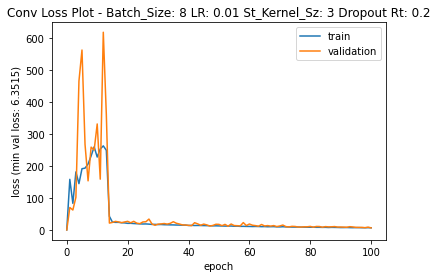

In [122]:
#string prep
file_name = "plots/conv_lossPlot_" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE) + "_" + str(START_KERNEL_SIZE) + "_" + str(DROPOUT_RATE) + ".png"
title =  "Conv Loss Plot - Batch_Size: " + str(BATCH_SIZE) + " LR: " + str(LEARNING_RATE) + " St_Kernel_Sz: " + str(START_KERNEL_SIZE) + " Dropout Rt: " + str(DROPOUT_RATE)
min_val_loss = round(min(avg_val_loss_list),4)
y_axis = "loss (min val loss: " + str(min_val_loss) + ")"

#axis/graph prep
avg_train_loss_list.insert(0,0)
avg_val_loss_list.insert(0,0)
x_axis = np.arange(0,(NUM_EPOCHS + 1),1)


plt.plot(x_axis, avg_train_loss_list, label='train')
plt.plot(x_axis, avg_val_loss_list, label='validation')
plt.xlabel('epoch')
plt.ylabel(y_axis)
plt.title(title)
plt.legend()
plt.savefig(file_name)

plt.show();

## Optional - Simple Recurrent Model

In [17]:
# Simple Convolution Model Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

In [ ]:
# Convolution Recurrent code
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

recurrent_model = SimpleRecurrentModel.SimpleRecurrentModel(input_size=, output_size=, hidden_dimensions=, n_layers=)).to(device) #####UPDATE PARAMETERS
optimizer = optim.Adam(convolution_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

for epoch_idx in range(NUM_EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")
    
    train_loss, avg_train_loss = utils.train(recurrent_model, train_loader, optimizer, criterion)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = utils.evaluate(recurrent_model, val_loader, criterion)

    avg_train_loss = avg_train_loss.item()
    avg_val_loss = avg_val_loss.item()
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))

    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)

In [ ]:
#string prep
file_name = "plots/rnn_lossPlot_" + str(BATCH_SIZE) + "_" + str(LEARNING_RATE) + ".png"
title =  "RNN Loss Plot - Batch_Size: " + str(BATCH_SIZE) + " LR: " + str(LEARNING_RATE)
y_axis = "loss (min val loss: " + str(min_val_loss) + ")"

#axis/graph prep
avg_train_loss_list.insert(0,0)
avg_val_loss_list.insert(0,0)
x_axis = np.arange(0,(NUM_EPOCHS + 1),1)


plt.plot(x_axis, avg_train_loss_list, label='train')
plt.plot(x_axis, avg_val_loss_list, label='validation')
plt.xlabel('epoch')
plt.ylabel(y_axis)
plt.title(title)
plt.legend()
plt.savefig(file_name)

plt.show();

## Optional - Model Evaluation

Pick a model that was trained above and push the evaluation data through it, and compute the model metrics

In [126]:
# First, load the evaluation data
eval_data = utils.load_pytorch_tensor('./utils/eval_data.pt')
eval_label = utils.load_pytorch_tensor('./utils/eval_label.pt')

# make this multi-classification problem a binary classification problem
eval_label, count = utils.convert_multiclass_to_binary(0, eval_label)
print("Total of " + str(count) + " positive examples out of " + str(eval_label.shape[0]) + " samples")

eval_data = np.float32(eval_data)

# put on the right device - for evaluation, we always run from CPU
eval_data = torch.from_numpy(eval_data).to('cpu')
eval_label = torch.from_numpy(eval_label).to('cpu')

# Next, pick the model you want to evaluate
# options: linear_model, convolution_model, recurrent_model 
model = linear_model 

# place the model on the CPU as well
model = model.cpu()

print(eval_data.is_cuda)
print(eval_label.is_cuda)


# push the eval data through the model
eval_dataset = dataloader.MusicDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)


# declare the metric keepers
conf_mat = ConfusionMatrix(num_classes=2)
f1_score = F1(num_classes=2)
total_accuracy = 0.0

with torch.no_grad():
  # Get the progress bar
  progress_bar = tqdm_notebook(eval_loader, ascii=True)
  for batch_idx, data in enumerate(progress_bar):
      input_data = data[0].to('cpu')
      correct_labels = data[1].to('cpu')

      prediction = model(input_data)

      conf_mat.update(prediction, correct_labels)
      f1_score.update(prediction, correct_labels)
      accuracy = torchmetrics.functional.accuracy(prediction, correct_labels)
      total_accuracy += accuracy
      progress_bar.set_description_str(
          "Batch: %d" % (batch_idx + 1))

# avg_acc, conf_mat, f1_score = utils.evaluate_with_metrics(model, eval_loader)
avg_accuracy = total_accuracy / len(eval_loader)
final_conf_mat = conf_mat.compute()
final_f1_score = f1_score.compute()

print("Model achieved an average accuracy of %.4f on evaluation data" % avg_accuracy.item())
print("Confusion Matrix:")
print(str(final_conf_mat))
print("F1 Score: %.4f" % final_f1_score.item())

Total of 5233 positive examples out of 19976 samples
False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/625 [00:00<?, ?it/s]

Model achieved an average accuracy of 0.8059 on evaluation data
Confusion Matrix:
tensor([[12941.,  1802.],
        [ 2079.,  3154.]])
F1 Score: 0.8057
